In [ ]:
# BUAN 6340.501 – Programming for Data Science - S18

                                                                            Project work submitted by:
                                                                                       - Aniparna Sengupta, axs169330

## [TABLE OF CONTENTS](#Table-of-contents)

1. [INTRODUCTION](#INTRODUCTION)

2. [THE PROBLEM DOMAIN](#THE-PROBLEM-DOMAIN)

3. [DATA DICTIONARY](#DATA-DICTIONARY)

4. [USED LIBRARIES](#USED-LIBRARIES)

5. [EXPLORATION DATA ANALYSIS](#EXPLORATION-DATA-ANALYSIS)

6. [DATA CLEANING FOR PREDICTIVE MODEL](#DATA-CLEANING-FOR-PREDICTIVE-MODEL)

7. [FINE TUNING AND RUNNING PREDICTIVE MODEL](#FINE-TUNING-AND-RUNNING-PREDICTIVE-MODEL)

8. [CONCLUSION](#CONCLUSION)

## INTRODUCTION

[[ go back to the top ]](#Table-of-contents)


Instacart is a grocery ordering and delivery application who help customers to get pantry items immediately delivered to their home. After selecting products through the Instacart application, personal shoppers review their order and do the in-store shopping and delivery for customers.


## THE PROBLEM DOMAIN

[[ go back to the top ]](#Table-of-contents)

The goal of our project is to predict which previously purchased product will be in user’s next order list. For example: Milk is ready to be added to the user’s cart automatically when user runs out of the item.

We will be using  user’s purchase history dataset which includes user’s order detail, product detail, data regarding time period between each order placed by the user etc. The dataset is anonymized and contains a sample of over 3 million grocery orders from more than 200,000 Instacart users. The dataset captured those customers who have made minimum of 4 orders and maximum of 100 orders

In the explanatory analysis, we will be analyzing relation between the item ordered over time with user details

In the predictive analysis, we will focus on probability of the product occurrence in user’s next order.

## *Instacart Market Basket Analysis*
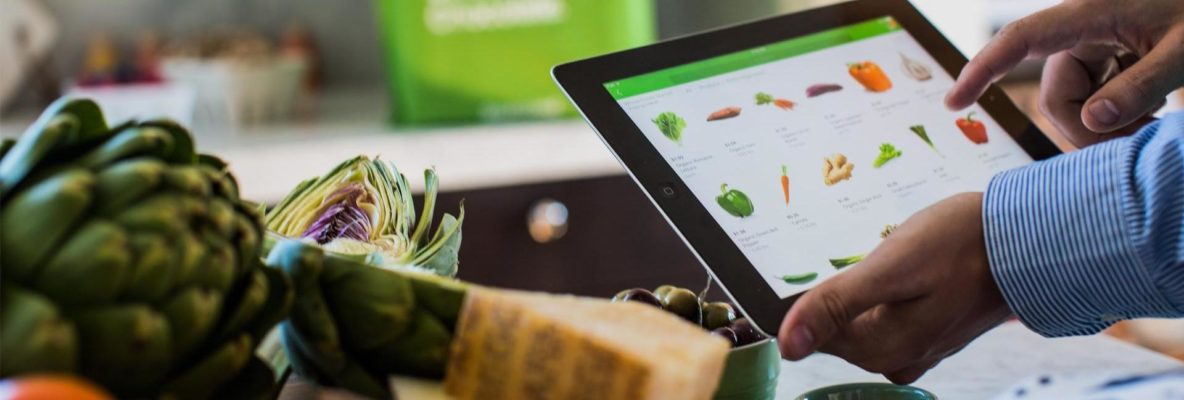

## DATA DICTIONARY

[[ go back to the top ]](#Table-of-contents)

Each entity (customer, product, order, aisle, etc.) has an associated unique id. Most of the files and variable names are self-explanatory.

### *aisles.csv*

This file contains information on aisle

 
### *departments.csv 

This file contains information about product department

### *order_products__*.csv

File contain order history details of customers and recent customer purchase information

 
### *orders.csv

File contain order details over time

 
### *products.csv
This file contain product information

 


## USED LIBRARIES

[[ go back to the top ]](#Table-of-contents)

This notebook uses several Python packages that come standard with the Anaconda Python distribution. The primary libraries that we'll be using are:

* **NumPy**: Provides a fast numerical array structure and helper functions.
* **pandas**: Provides a DataFrame structure to store data in memory and work with it easily and efficiently.
* **scikit-learn**: The essential Machine Learning package in Python.
* **matplotlib**: Basic plotting library in Python; most other Python plotting libraries are built on top of it.
* **Seaborn**: Advanced statistical plotting library.

## EXPLORATION DATA ANALYSIS

[[ go back to the top ]](#Table-of-contents)

Let us start by importing the necessary modules.

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline
IDIR = 'D:/market basket analysis/All_data/'

We will now read all required files as dataframe objects for better understanding before moving forward with exploratory analysis.

In [ ]:
order_products_train_df = pd.read_csv(IDIR +'order_products__train.csv')
order_products_prior_df = pd.read_csv(IDIR +'order_products__prior.csv')
orders_df = pd.read_csv(IDIR +'orders.csv')
products_df = pd.read_csv(IDIR +'products.csv')
aisles_df = pd.read_csv(IDIR +'aisles.csv')
departments_df = pd.read_csv(IDIR +'departments.csv')

In [3]:
orders_df.head()


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [4]:
order_products_prior_df.head()


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [5]:
order_products_train_df.head()


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


We can state that orders.csv has all the information about the given orders

The columns present in order_products_train and order_products_prior are same. The only difference is that prior dataset consist of user's purchase history whereas train dataset consist of user's recent order details. We will be using train dataset to predict product reorder probability.

Order_products*csv file has more detailed information about the products that been bought in the given order along with the re-ordered status.


Let us first get the count of rows in each of the three sets in order.csv file.

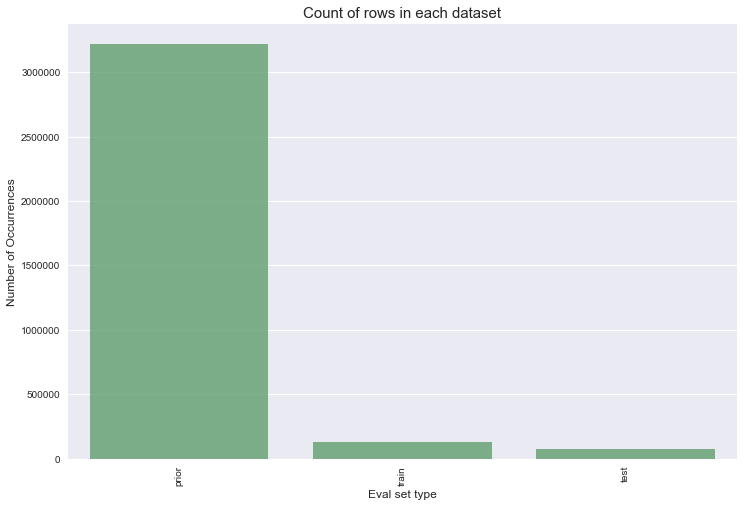

In [6]:
cnt_srs = orders_df.eval_set.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[1])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Eval set type', fontsize=12)
plt.title('Count of rows in each dataset', fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

In [7]:
def get_unique_count(x):
    return len(np.unique(x))

cnt_srs = orders_df.groupby("eval_set")["user_id"].aggregate(get_unique_count)
cnt_srs

eval_set
prior    206209
test      75000
train    131209
Name: user_id, dtype: int64

So there are 206,209 customers in total. Out of which, the last purchase of 131,209 customers are given as train set and we need to predict for the rest 75,000 customers.

Now let us validate the claim that 4 to 100 orders of a customer are given.

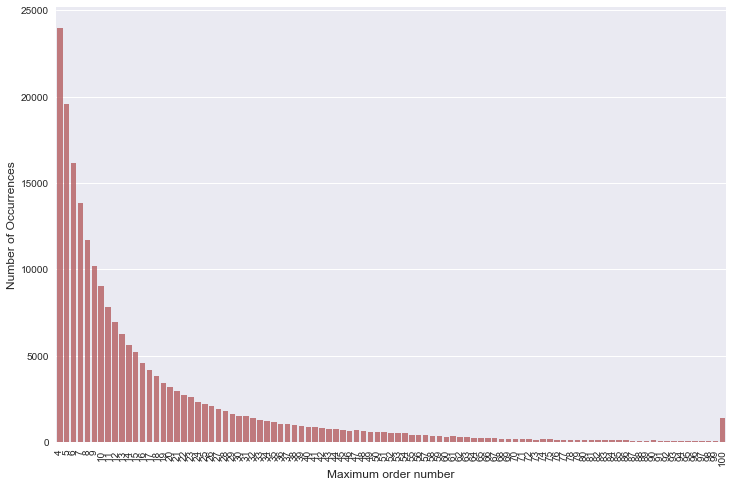

In [8]:
cnt_srs = orders_df.groupby("user_id")["order_number"].aggregate(np.max).reset_index()
cnt_srs = cnt_srs.order_number.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[2])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Maximum order number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

So there are no orders less than 4 and is max capped at 100 as given in the data page.

Now let us see how the ordering habit changes with day of week.

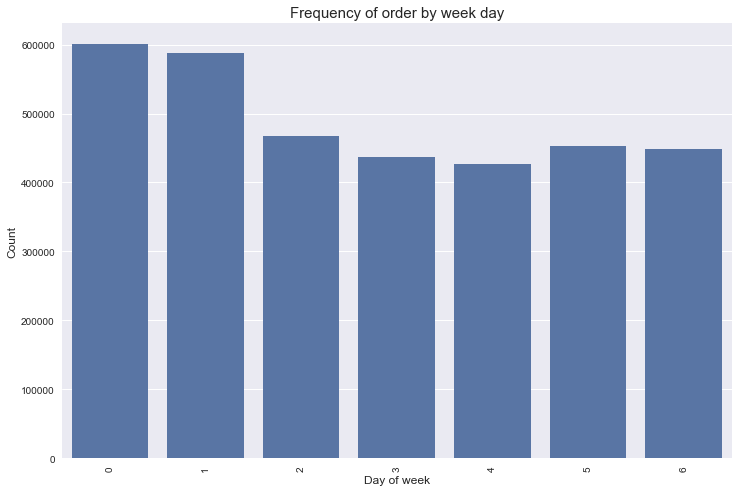

In [9]:
plt.figure(figsize=(12,8))
sns.countplot(x="order_dow", data=orders_df, color=color[0])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by week day", fontsize=15)
plt.show()

Seems like 0 and 1 is Saturday and Sunday when the orders are high and low during Wednesday.

Now we shall see how the distribution is with respect to time of the day.

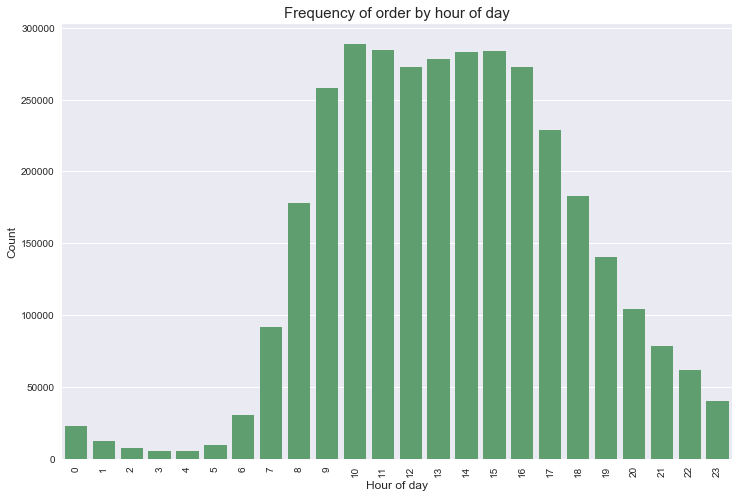

In [10]:
plt.figure(figsize=(12,8))
sns.countplot(x="order_hour_of_day", data=orders_df, color=color[1])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by hour of day", fontsize=15)
plt.show()


So majority of the orders are made during day time. Now let us combine the day of week and hour of day to see the distribution.

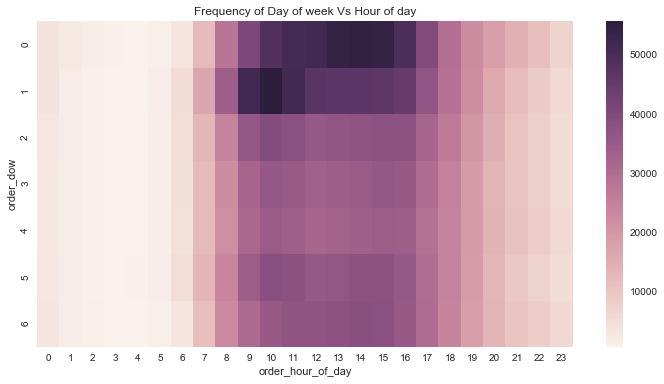

In [11]:
grouped_df = orders_df.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count").reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'order_number')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)
plt.title("Frequency of Day of week Vs Hour of day")
plt.show()

Seems Satuday evenings and Sunday mornings are the prime time for orders.

Now let us check the time interval between the orders.

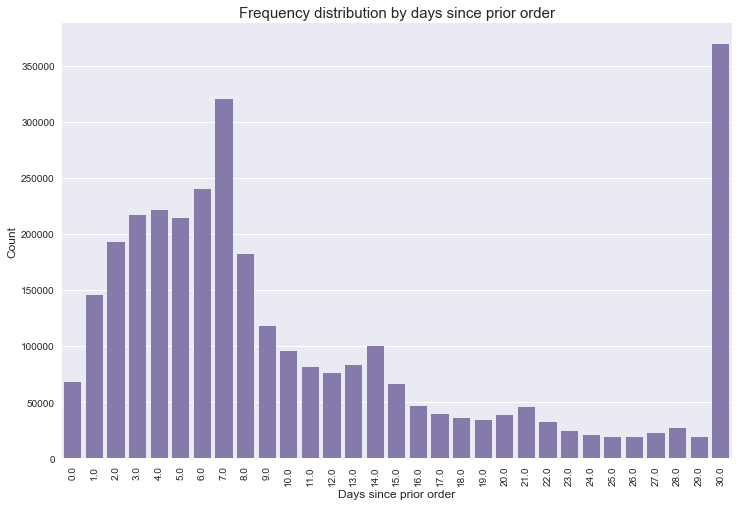

In [12]:
plt.figure(figsize=(12,8))
sns.countplot(x="days_since_prior_order", data=orders_df, color=color[3])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Days since prior order', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency distribution by days since prior order", fontsize=15)
plt.show()

Looks like customers order once in every week due to peak rise on 7days or once in a month beacuse of peak rise in 30 days. We could also see smaller peaks at 14, 21 and 28 days which are mostly weekly intervals.

Since our objective is to figure out the re-orders, let us check out the re-order percentage in prior set and train set.

In [13]:
 #percentage of re-orders in prior set #
order_products_prior_df.reordered.sum() / order_products_prior_df.shape[0]

0.5896974667922161

In [14]:
# percentage of re-orders in train set #
order_products_train_df.reordered.sum() / order_products_train_df.shape[0]

0.5985944127509629

On an average, about 59% of the products in an order are re-ordered products.

Now that we have seen 59% of the products are re-ordered, there will also be situations when none of the products are re-ordered. Thus below we calculate value if none product is re-ordered.

In [15]:
grouped_df = order_products_prior_df.groupby("order_id")["reordered"].aggregate("sum").reset_index()
grouped_df["reordered"].ix[grouped_df["reordered"]>1] = 1
grouped_df.reordered.value_counts() / grouped_df.shape[0]

C:\Users\sopas\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  


1    0.879151
0    0.120849
Name: reordered, dtype: float64

In [16]:
grouped_df = order_products_train_df.groupby("order_id")["reordered"].aggregate("sum").reset_index()
grouped_df["reordered"].ix[grouped_df["reordered"]>1] = 1
grouped_df.reordered.value_counts() / grouped_df.shape[0]

C:\Users\sopas\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  


1    0.93444
0    0.06556
Name: reordered, dtype: float64

Thus we can see that 12% of the products were not re-ordered in the prior dataset and 6.5% of data has no reorder count in train dataset
Now let us see the number of products bought in each order.

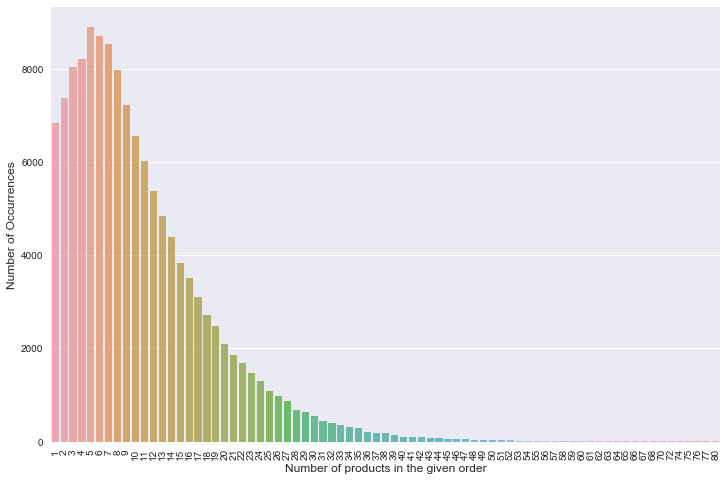

In [17]:
grouped_df = order_products_train_df.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()
cnt_srs = grouped_df.add_to_cart_order.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of products in the given order', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()


5th order has more of occurance.

Before we explore the product details, let us look at the other three files as well.

In [18]:
products_df.head()


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [19]:
aisles_df.head()


,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [20]:
departments_df.head()


,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


Now let us merge these product details with the order_prior details.



In [21]:
order_products_prior_df = pd.merge(order_products_prior_df, products_df, on='product_id', how='left')
order_products_prior_df = pd.merge(order_products_prior_df, aisles_df, on='aisle_id', how='left')
order_products_prior_df = pd.merge(order_products_prior_df, departments_df, on='department_id', how='left')
order_products_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry


In [22]:
order_products_prior_df.describe()

,order_id,product_id,add_to_cart_order,reordered,aisle_id,department_id
count,3.243449e+07,3.243449e+07,3.243449e+07,3.243449e+07,3.243449e+07,3.243449e+07
mean,1.710749e+06,2.557634e+04,8.351076e+00,5.896975e-01,7.121430e+01,9.921906e+00
std,9.873007e+05,1.409669e+04,7.126671e+00,4.918886e-01,3.820302e+01,6.281156e+00
min,2.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
25%,8.559430e+05,1.353000e+04,3.000000e+00,0.000000e+00,3.100000e+01,4.000000e+00
50%,1.711048e+06,2.525600e+04,6.000000e+00,1.000000e+00,8.300000e+01,9.000000e+00
75%,2.565514e+06,3.793500e+04,1.100000e+01,1.000000e+00,1.070000e+02,1.600000e+01
max,3.421083e+06,4.968800e+04,1.450000e+02,1.000000e+00,1.340000e+02,2.100000e+01


In [23]:
cnt_srs = order_products_prior_df['product_name'].value_counts().reset_index().head(20)
cnt_srs.columns = ['product_name', 'frequency_count']
cnt_srs

,product_name,frequency_count
0,Banana,472565
1,Bag of Organic Bananas,379450
2,Organic Strawberries,264683
3,Organic Baby Spinach,241921
4,Organic Hass Avocado,213584
5,Organic Avocado,176815
6,Large Lemon,152657
7,Strawberries,142951
8,Limes,140627
9,Organic Whole Milk,137905


We can see that most of the products ordered are organic and mostly fruits.

Now let us look at the important aisles.

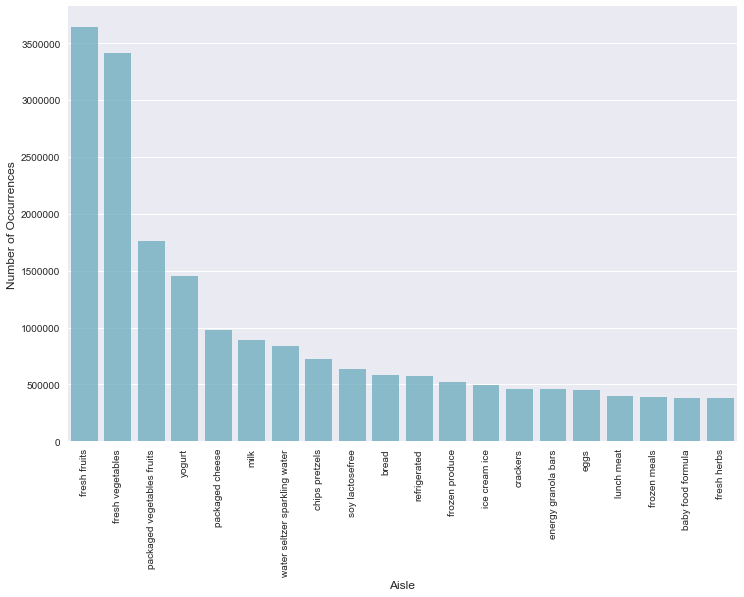

In [24]:
cnt_srs = order_products_prior_df['aisle'].value_counts().head(20)
plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[5])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Aisle', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

Fresh fruit and vegetables are two aisle where most of the products are ordered. These shows that fruits and vegetables have high chance of being re-ordered.


### Most important Aisles in each Department (by number of Products)


C:\Users\sopas\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


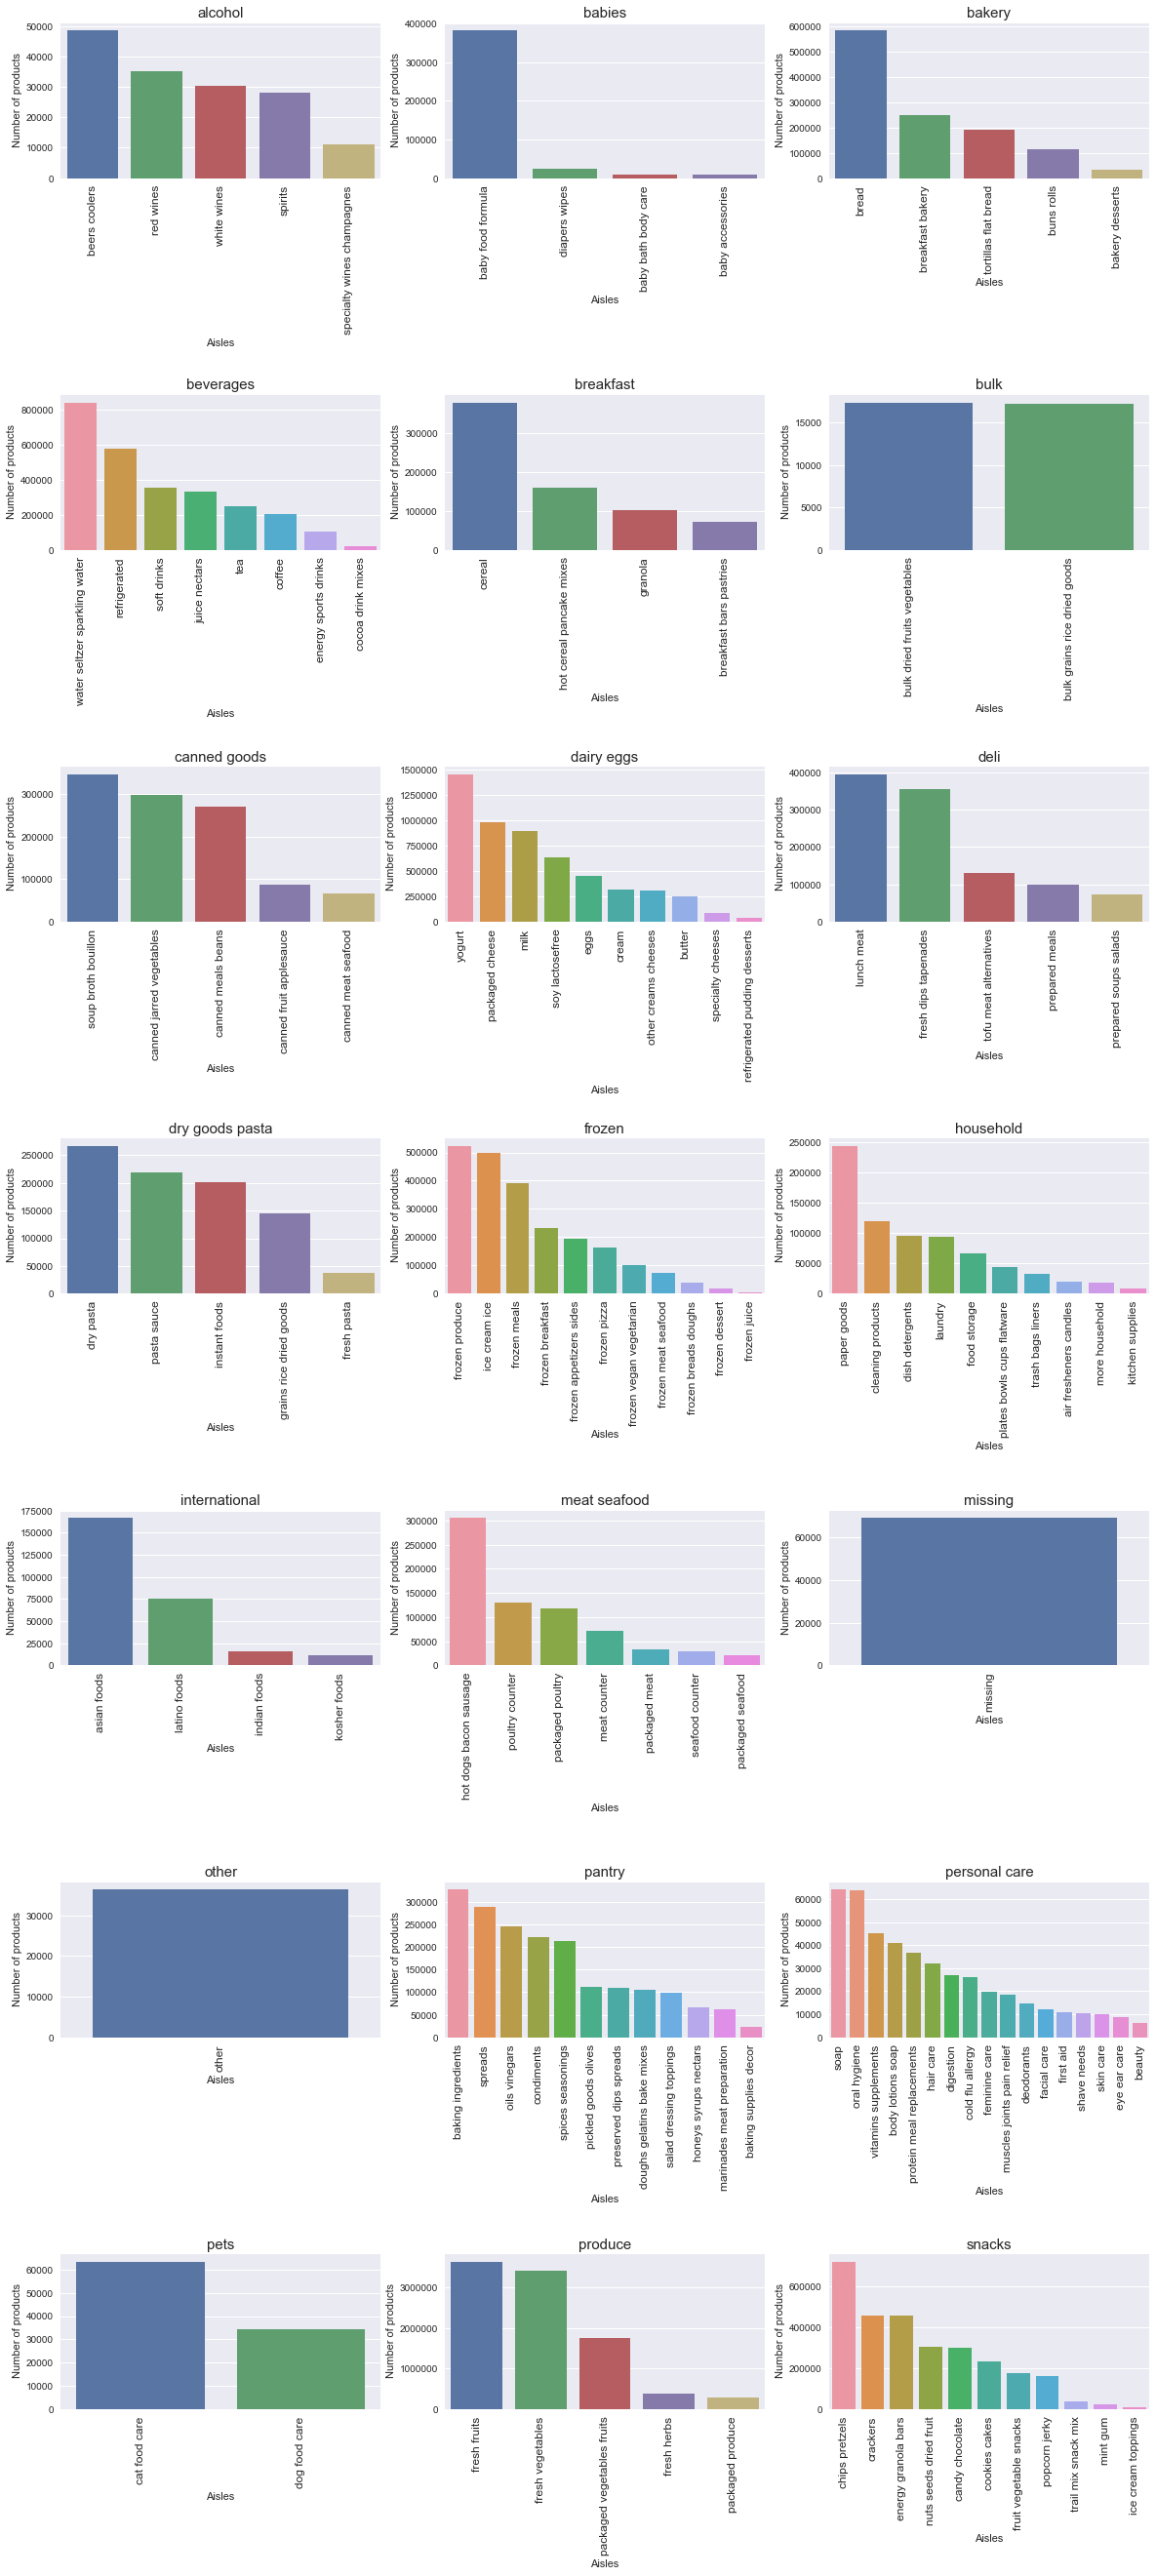

In [25]:
grouped = order_products_prior_df.groupby(["department", "aisle"])["product_id"].aggregate({'Total_products': 'count'}).reset_index()
grouped.sort_values(by='Total_products', ascending=False, inplace=True)
fig, axes = plt.subplots(7,3, figsize=(20,45), gridspec_kw =  dict(hspace=1.4))
for (aisle, group), ax in zip(grouped.groupby(["department"]), axes.flatten()):
    g = sns.barplot(group.aisle, group.Total_products , ax=ax)
    ax.set(xlabel = "Aisles", ylabel=" Number of products")
    g.set_xticklabels(labels = group.aisle,rotation=90, fontsize=12)
    ax.set_title(aisle, fontsize=15)

### Department Distribution:

Let us now check the department wise distribution.

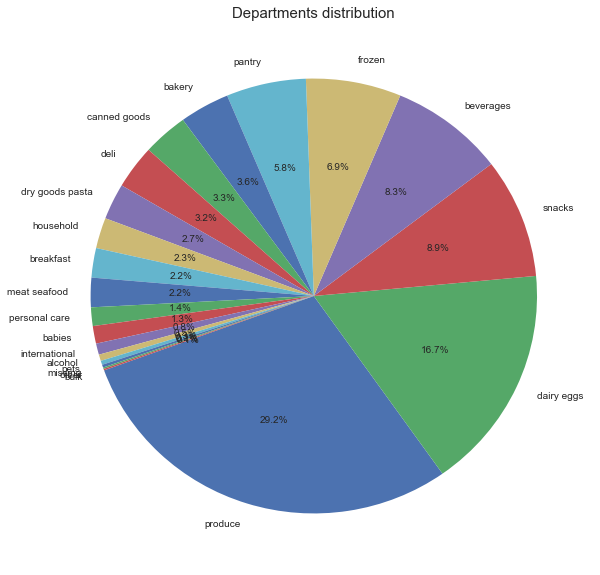

In [26]:
plt.figure(figsize=(10,10))
temp_series = order_products_prior_df['department'].value_counts()
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series / temp_series.sum())*100))
plt.pie(sizes, labels=labels, 
        autopct='%1.1f%%', startangle=200)
plt.title("Departments distribution", fontsize=15)
plt.show()

Produce is the largest department. Now let us check the reordered percentage of each department.



### Department wise reorder ratio:



Now we need to analyse how many times the product was re-ordered based on each department

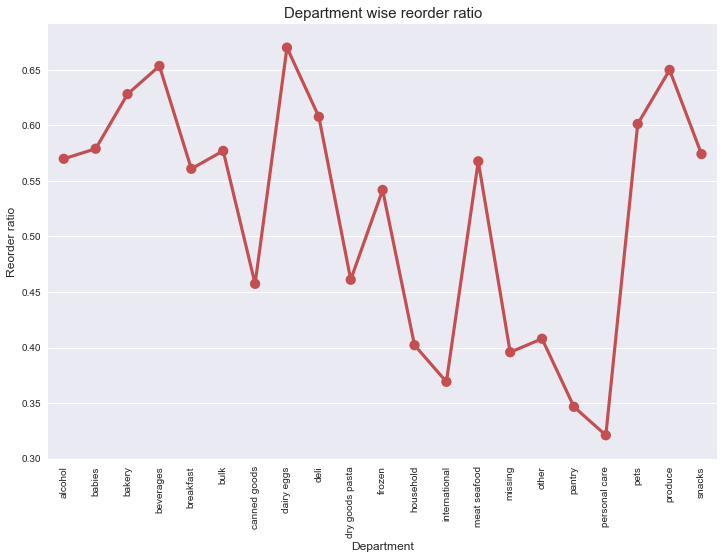

In [27]:
grouped_df = order_products_prior_df.groupby(["department"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.pointplot(grouped_df['department'].values, grouped_df['reordered'].values, alpha=0.8, color=color[2])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Department', fontsize=12)
plt.title("Department wise reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()




From the above distribution plot we can state that Dairy eggs has higher re-order ratio compared to personal care department

### Add to Cart - Reorder ratio:

We will now look into the re-order of the products based on each number of products added to the cart

C:\Users\sopas\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  
C:\Users\sopas\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


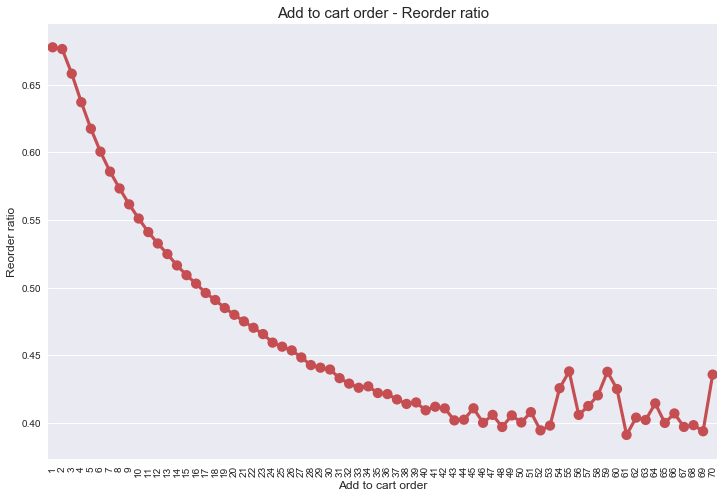

In [28]:
order_products_prior_df["add_to_cart_order_mod"] = order_products_prior_df["add_to_cart_order"].copy()
order_products_prior_df["add_to_cart_order_mod"].ix[order_products_prior_df["add_to_cart_order_mod"]>70] = 70
grouped_df = order_products_prior_df.groupby(["add_to_cart_order_mod"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.pointplot(grouped_df['add_to_cart_order_mod'].values, grouped_df['reordered'].values, alpha=0.8, color=color[2])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Add to cart order', fontsize=12)
plt.title("Add to cart order - Reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

We can observe that product added initially are most reorder compared to the items added later to the cart. The reason is that we tend to buy item which we buy frequently and then look for other items.


### Reorder ratio by Time based variables:

We now need to analyse the reorder ratio based on time of the day

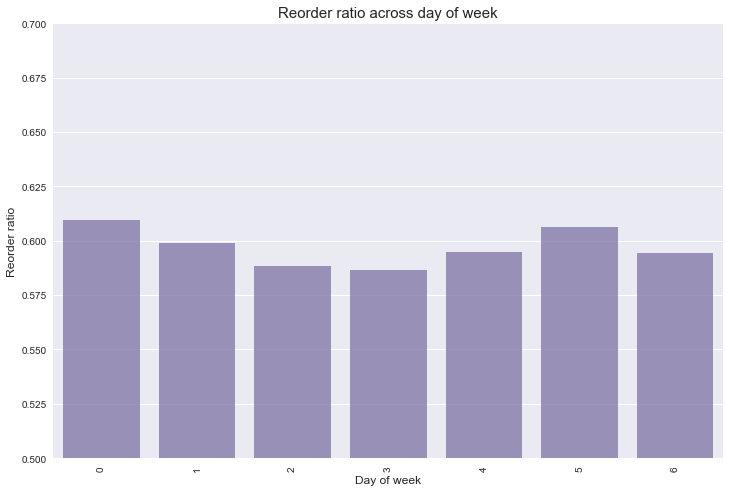

In [29]:
order_products_train_df = pd.merge(order_products_train_df, orders_df, on='order_id', how='left')
grouped_df = order_products_train_df.groupby(["order_dow"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.barplot(grouped_df['order_dow'].values, grouped_df['reordered'].values, alpha=0.8, color=color[3])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.title("Reorder ratio across day of week", fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.7)
plt.show()

From the above plot we can note that most of the reorder has occured during Sunday and Friday

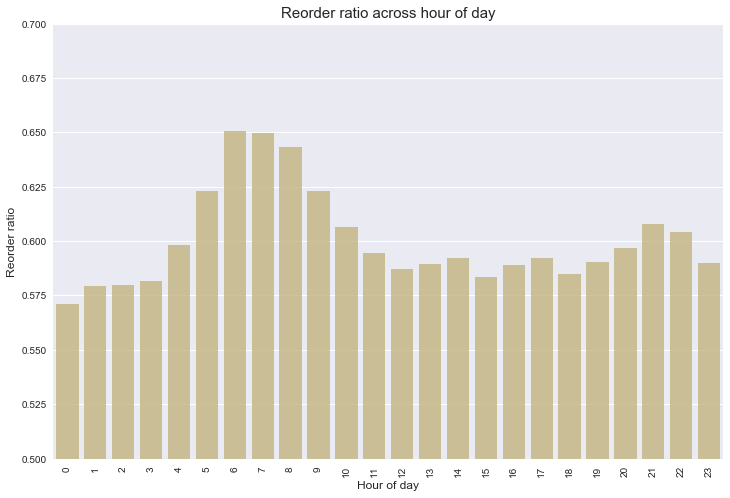

In [30]:
grouped_df = order_products_train_df.groupby(["order_hour_of_day"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.barplot(grouped_df['order_hour_of_day'].values, grouped_df['reordered'].values, alpha=0.8, color=color[4])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.title("Reorder ratio across hour of day", fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.7)
plt.show()


The above plot states that early morning has more reorder count compared to evening

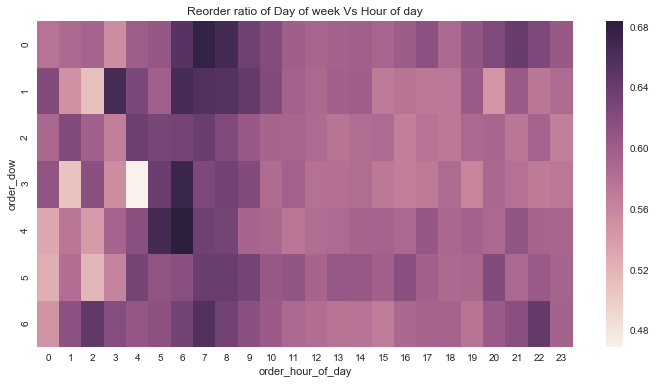

In [35]:
grouped_df = order_products_train_df.groupby(["order_dow", "order_hour_of_day"])["reordered"].aggregate("mean").reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'reordered')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)
plt.title("Reorder ratio of Day of week Vs Hour of day")
plt.show()

Looks like reorder ratios are quite high during the early mornings compared to later half of the day.



## DATA CLEANING FOR PREDICTIVE MODEL

[[ go back to the top ]](#Table-of-contents)

Reloading the data based on selected columns required for predictive model.
Our goal is to predict the product ids for user's next order
We need to map all the product ids which user is going to order based on his/her order id

In [84]:
print('loading prior')
priors = pd.read_csv(IDIR + 'order_products__prior.csv', dtype={
            'order_id': np.int32,
            'product_id': np.uint16,
            'add_to_cart_order': np.int16,
            'reordered': np.int8})

print('loading train')
train = pd.read_csv(IDIR + 'order_products__train.csv', dtype={
            'order_id': np.int32,
            'product_id': np.uint16,
            'add_to_cart_order': np.int16,
            'reordered': np.int8})


print('loading orders')
orders = pd.read_csv(IDIR + 'orders.csv', dtype={
        'order_id': np.int32,
        'user_id': np.int32,
        'eval_set': 'category',
        'order_number': np.int16,
        'order_dow': np.int8,
        'order_hour_of_day': np.int8,
        'days_since_prior_order': np.float32})


print('loading products')
products = pd.read_csv(IDIR + 'products.csv', dtype={
        'product_id': np.uint16,
        'order_id': np.int32,
        'aisle_id': np.uint8,
        'department_id': np.uint8},
        usecols=['product_id', 'aisle_id', 'department_id'])


print('priors {}: {}'.format(priors.shape, ', '.join(priors.columns)))
print('orders {}: {}'.format(orders.shape, ', '.join(orders.columns)))
print('train {}: {}'.format(train.shape, ', '.join(train.columns)))
print('products {}: {}'.format(products.shape, ', '.join(products.head())))


loading prior
loading train
loading orders
loading products
priors (32434489, 4): order_id, product_id, add_to_cart_order, reordered
orders (3421083, 7): order_id, user_id, eval_set, order_number, order_dow, order_hour_of_day, days_since_prior_order
train (1384617, 4): order_id, product_id, add_to_cart_order, reordered
products (49688, 3): product_id, aisle_id, department_id


We will now look into the dataset and its data type for better understanding

In [85]:
priors.head()


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [86]:
orders.head()


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [87]:
train.head()


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [88]:
products.head()


,product_id,aisle_id,department_id
0,1,61,19
1,2,104,13
2,3,94,7
3,4,38,1
4,5,5,13


The reason to choose below columns in the dataset is based on the descriptive analysis. We have noticed that department, aisle, product, reorder play important role to explain the user's next order product details.

We can note the following detail from the above datasets:
    
    1. priors dataset states the information of the product based on the order and number of time item was re-ordered
    2. order dataset contains information of the users placing the order (time, order_id)
    3. train datset is similar to prior data, the only difference is that it contain the recent order information about the customer.
    4. products dataset consist information of departments and aisle

In [89]:
print('computing product features')
prods = pd.DataFrame()
prods['orders'] = priors.groupby(priors.product_id).size().astype(np.int32)
prods['reorders'] = priors['reordered'].groupby(priors.product_id).sum().astype(np.float32)
prods['reorder_rate'] = (prods.reorders / prods.orders).astype(np.float32)
products = products.join(prods, on='product_id')
products.set_index('product_id', drop=False, inplace=True)
del prods

computing product features


In [90]:
products.head()


,product_id,aisle_id,department_id,orders,reorders,reorder_rate
product_id,,,,,,
1,1,61,19,1852.0,1136.0,0.613391
2,2,104,13,90.0,12.0,0.133333
3,3,94,7,277.0,203.0,0.732852
4,4,38,1,329.0,147.0,0.446809
5,5,5,13,15.0,9.0,0.600000


From the above dataset, we calculated the reorder rate based on (total number of reorder/total number of order) per product_id

In [91]:
print('add order information to priors')
orders.set_index('order_id', inplace=True, drop=False)
priors = priors.join(orders, on='order_id', rsuffix='_')
priors.drop('order_id_', inplace=True, axis=1)
priors.head()

add order information to priors


,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,202279,prior,3,5,9,8.0
1,2,28985,2,1,202279,prior,3,5,9,8.0
2,2,9327,3,0,202279,prior,3,5,9,8.0
3,2,45918,4,1,202279,prior,3,5,9,8.0
4,2,30035,5,0,202279,prior,3,5,9,8.0


The reason we added up order with prior as we need to calculate metrics based on each user as stated below

### User Features

In [92]:
print('computing user features')
usr = pd.DataFrame()
usr['average_days_between_orders'] = orders.groupby('user_id')['days_since_prior_order'].mean().astype(np.float32)
usr['nb_orders'] = orders.groupby('user_id').size().astype(np.int16)
usr.head()

computing user features


,average_days_between_orders,nb_orders
user_id,,
1,19.000000,11
2,16.285715,15
3,12.000000,13
4,17.000000,6
5,11.500000,5


Here nb_order means total number of orders placed by each user
average_days_between_orders	 means average time taken by the user from the recent prior order date to current order date

In [93]:
users = pd.DataFrame()
users['total_items'] = priors.groupby('user_id').size().astype(np.int16)
users['all_products'] = priors.groupby('user_id')['product_id'].apply(set)
users['total_distinct_items'] = (users.all_products.map(len)).astype(np.int16)
users.head()

,total_items,all_products,total_distinct_items
user_id,,,
1,59,"{17122, 196, 26405, 46149, 14084, 13032, 26088...",18
2,195,"{45066, 2573, 18961, 23, 32792, 1559, 22559, 1...",102
3,88,"{17668, 44683, 48523, 21903, 14992, 21137, 324...",33
4,18,"{21573, 42329, 17769, 35469, 37646, 1200, 1905...",17
5,37,"{11777, 40706, 28289, 48775, 20754, 6808, 1398...",23


In the above calculation, we have accumulated all the product ids which user ordered based on each user_id

In [94]:
users = users.join(usr)
del usr
users['average_basket'] = (users.total_items / users.nb_orders).astype(np.float32)
print('user data size', users.shape)

user data size (206209, 6)


In [95]:
users.head()

,total_items,all_products,total_distinct_items,average_days_between_orders,nb_orders,average_basket
user_id,,,,,,
1,59,"{17122, 196, 26405, 46149, 14084, 13032, 26088...",18,19.000000,11,5.363636
2,195,"{45066, 2573, 18961, 23, 32792, 1559, 22559, 1...",102,16.285715,15,13.000000
3,88,"{17668, 44683, 48523, 21903, 14992, 21137, 324...",33,12.000000,13,6.769231
4,18,"{21573, 42329, 17769, 35469, 37646, 1200, 1905...",17,17.000000,6,3.000000
5,37,"{11777, 40706, 28289, 48775, 20754, 6808, 1398...",23,11.500000,5,7.400000


Now we will perform linear combination between user_id and product_ids to calculate metrics

### User_X_Product Features

In [96]:
userXproduct = priors.copy()
userXproduct['user_product'] = userXproduct.product_id + userXproduct.user_id * 100000
userXproduct.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,user_product
0,2,33120,1,1,202279,prior,3,5,9,8.0,-1246903360
1,2,28985,2,1,202279,prior,3,5,9,8.0,-1246907495
2,2,9327,3,0,202279,prior,3,5,9,8.0,-1246927153
3,2,45918,4,1,202279,prior,3,5,9,8.0,-1246890562
4,2,30035,5,0,202279,prior,3,5,9,8.0,-1246906445


In [97]:
userXproduct = userXproduct.sort_values('order_number')
userXproduct = userXproduct.groupby('user_product', sort=False).agg({'order_id': ['size', 'last'], 'add_to_cart_order': 'sum'})
userXproduct.columns = ['nb_orders', 'last_order_id', 'sum_pos_in_cart']
userXproduct.astype(
    {'nb_orders': np.int16, 'last_order_id': np.int32, 'sum_pos_in_cart': np.int16}, 
    inplace=True)
del priors

In [98]:
userXproduct.head()


,nb_orders,last_order_id,sum_pos_in_cart
user_product,,,
33971483,1,1520399,14
-1750527855,1,2049062,3
-1750546103,3,1489630,8
-1750547657,3,2251505,14
-1750534134,4,2251505,18


sum_pos_in_cart means total number of orders added to the cart based on the linear combination of user_id and product_id

In [100]:
userXproduct.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 13293564 entries, 33971483 to -427400945
Data columns (total 3 columns):
nb_orders          int64
last_order_id      int32
sum_pos_in_cart    int16
dtypes: int16(1), int32(1), int64(1)
memory usage: 278.9 MB


### train / test orders 

Now we will divide the dataset to test dataset and train dataset. 

In [101]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
order_id,,,,,,,
2539329,2539329,1,prior,1,2,8,NaN
2398795,2398795,1,prior,2,3,7,15.0
473747,473747,1,prior,3,3,12,21.0
2254736,2254736,1,prior,4,4,7,29.0
431534,431534,1,prior,5,4,15,28.0


In [102]:
orders.eval_set.unique()


[prior, train, test]
Categories (3, object): [prior, train, test]

In [103]:
print('split orders : train, test')
test_orders = orders[orders.eval_set == 'test']
train_orders = orders[orders.eval_set == 'train']

split orders : train, test


In [104]:
test_orders.head()


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
order_id,,,,,,,
2774568,2774568,3,test,13,5,15,11.0
329954,329954,4,test,6,3,12,30.0
1528013,1528013,6,test,4,3,16,22.0
1376945,1376945,11,test,8,6,11,8.0
1356845,1356845,12,test,6,1,20,30.0


In [105]:
test_orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75000 entries, 2774568 to 803273
Data columns (total 7 columns):
order_id                  75000 non-null int32
user_id                   75000 non-null int32
eval_set                  75000 non-null category
order_number              75000 non-null int16
order_dow                 75000 non-null int8
order_hour_of_day         75000 non-null int8
days_since_prior_order    75000 non-null float32
dtypes: category(1), float32(1), int16(1), int32(2), int8(2)
memory usage: 1.8 MB


In [106]:
train_orders.head()


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
order_id,,,,,,,
1187899,1187899,1,train,11,4,8,14.0
1492625,1492625,2,train,15,1,11,30.0
2196797,2196797,5,train,5,0,11,6.0
525192,525192,7,train,21,2,11,6.0
880375,880375,8,train,4,1,14,10.0


In [107]:
train_orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131209 entries, 1187899 to 272231
Data columns (total 7 columns):
order_id                  131209 non-null int32
user_id                   131209 non-null int32
eval_set                  131209 non-null category
order_number              131209 non-null int16
order_dow                 131209 non-null int8
order_hour_of_day         131209 non-null int8
days_since_prior_order    131209 non-null float32
dtypes: category(1), float32(1), int16(1), int32(2), int8(2)
memory usage: 3.1 MB


looking into the train dataset which we have loaded to the dataframe initially

In [108]:
train.head()


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [109]:
train.set_index(['order_id', 'product_id'], inplace=True, drop=False)
train.head()


order_id  product_id  add_to_cart_order  reordered
order_id product_id                                                    
1        49302              1       49302                  1          1
         11109              1       11109                  2          1
         10246              1       10246                  3          0
         49683              1       49683                  4          0
         43633              1       43633                  5          1

In [110]:
train.head(20).index.tolist()

[(1, 49302),
 (1, 11109),
 (1, 10246),
 (1, 49683),
 (1, 43633),
 (1, 13176),
 (1, 47209),
 (1, 22035),
 (36, 39612),
 (36, 19660),
 (36, 49235),
 (36, 43086),
 (36, 46620),
 (36, 34497),
 (36, 48679),
 (36, 46979),
 (38, 11913),
 (38, 18159),
 (38, 4461),
 (38, 21616)]

We have mapped the order_id and product id as index for the train dataset as we will be taking this reference to create label for our predictive model. 
We will be checking if the products in the train dataset is also present in the prior dataset. if its present label = 1 else 0.
label = 1 means the particular order has ben placed before by the same user.

## FINE TUNING AND RUNNING PREDICTIVE MODEL

[[ go back to the top ]](#Table-of-contents)


The below function will create dataset for training and test combining all the dataframe's required columns for preedictive modelling.

In [111]:
def features(selected_orders, labels_given=False):
    print('build candidate list')
    order_list = []
    product_list = []
    labels = []
    i=0
    train_index = set(train.index)     
    #print('train_index {}'.format(train_index))
    for row in selected_orders.itertuples():
        user_id = row.user_id
        order_id = row.order_id

        user_prods = users['all_products'][user_id]
        #print('user_prods {}'.format(user_prods))
        product_list += user_prods
        order_list += [order_id] * len(user_prods)
        #print('order_list {}'.format(order_list))
        #print('labels_given {}'.format(labels_given))

        if labels_given:
            labels += [(order_id, prod) in train_index for prod in user_prods]
           # print('labels {}'.format(labels))

    df = pd.DataFrame({'order_id':order_list, 'product_id':product_list}, dtype=np.int32)
    labels = np.array(labels, dtype=np.int8)
    #print('labels integer {}'.format(labels))
    del order_list
    del product_list
    
    print('user related features')
    df['user_id'] = df.order_id.map(orders.user_id)
    df['user_total_orders'] = df.user_id.map(users.nb_orders)
    df['user_total_items'] = df.user_id.map(users.total_items)
    df['total_distinct_items'] = df.user_id.map(users.total_distinct_items)
    df['user_average_days_between_orders'] = df.user_id.map(users.average_days_between_orders)
    df['user_average_basket'] =  df.user_id.map(users.average_basket)
    
    print('order related features')
    df['order_hour_of_day'] = df.order_id.map(orders.order_hour_of_day)
    df['days_since_prior_order'] = df.order_id.map(orders.days_since_prior_order)
    df['days_since_ratio'] = df.days_since_prior_order / df.user_average_days_between_orders
    
    print('product related features')
    df['aisle_id'] = df.product_id.map(products.aisle_id)
    df['department_id'] = df.product_id.map(products.department_id)
    df['product_orders'] = df.product_id.map(products.orders).astype(np.int32)
    df['product_reorders'] = df.product_id.map(products.reorders)
    df['product_reorder_rate'] = df.product_id.map(products.reorder_rate)

    print('user_X_product related features')
    df['z'] = df.user_id * 100000 + df.product_id
   # print('data before adding user_X_product related features')
   # print('{}'.format(df.head()))
    df.drop(['user_id'], axis=1, inplace=True)
    df['UP_orders'] = df.z.map(userXproduct.nb_orders)
    df['UP_orders_ratio'] = (df.UP_orders / df.user_total_orders).astype(np.float32)
    df['UP_last_order_id'] = df.z.map(userXproduct.last_order_id)
    df['UP_average_pos_in_cart'] = (df.z.map(userXproduct.sum_pos_in_cart) / df.UP_orders).astype(np.float32)
    df['UP_reorder_rate'] = (df.UP_orders / df.user_total_orders).astype(np.float32)
    df['UP_orders_since_last'] = df.user_total_orders - df.UP_last_order_id.map(orders.order_number)
    df['UP_delta_hour_vs_last'] = abs(df.order_hour_of_day - df.UP_last_order_id.map(orders.order_hour_of_day)).map(lambda x: min(x, 24-x)).astype(np.int8)
   # print('data before adding user_X_product related features')
   # print('{}'.format(df.head()))

    df.drop(['UP_last_order_id', 'z'], axis=1, inplace=True)
    print(df.dtypes)
    print(df.memory_usage())
    return (df, labels)

In [112]:
train_orders.head()


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
order_id,,,,,,,
1187899,1187899,1,train,11,4,8,14.0
1492625,1492625,2,train,15,1,11,30.0
2196797,2196797,5,train,5,0,11,6.0
525192,525192,7,train,21,2,11,6.0
880375,880375,8,train,4,1,14,10.0


### BUILD DATASET FOR PRODUCT LIST AND ITS FEATURES

In [113]:
from sklearn.model_selection import train_test_split

train_customers, valid_customers = train_test_split(train_orders,test_size=0.3,random_state=100)

#df_train_score, labels_train = features(test_orders, labels_given=True)


In [114]:
df_train, labels = features(train_orders, labels_given=True)


build candidate list
user related features
order related features
product related features
user_X_product related features
order_id                              int32
product_id                            int32
user_total_orders                     int16
user_total_items                      int16
total_distinct_items                  int16
user_average_days_between_orders    float32
user_average_basket                 float32
order_hour_of_day                      int8
days_since_prior_order              float32
days_since_ratio                    float32
aisle_id                              uint8
department_id                         uint8
product_orders                        int32
product_reorders                    float32
product_reorder_rate                float32
UP_orders                             int64
UP_orders_ratio                     float32
UP_average_pos_in_cart              float32
UP_reorder_rate                     float32
UP_orders_since_last                  int

In [115]:
df_valid, labels_valid = features(valid_customers, labels_given=True)

build candidate list
user related features
order related features
product related features
user_X_product related features
order_id                              int32
product_id                            int32
user_total_orders                     int16
user_total_items                      int16
total_distinct_items                  int16
user_average_days_between_orders    float32
user_average_basket                 float32
order_hour_of_day                      int8
days_since_prior_order              float32
days_since_ratio                    float32
aisle_id                              uint8
department_id                         uint8
product_orders                        int32
product_reorders                    float32
product_reorder_rate                float32
UP_orders                             int64
UP_orders_ratio                     float32
UP_average_pos_in_cart              float32
UP_reorder_rate                     float32
UP_orders_since_last                  int

In [116]:
df_train.head()


,order_id,product_id,user_total_orders,user_total_items,total_distinct_items,user_average_days_between_orders,user_average_basket,order_hour_of_day,days_since_prior_order,days_since_ratio,...,department_id,product_orders,product_reorders,product_reorder_rate,UP_orders,UP_orders_ratio,UP_average_pos_in_cart,UP_reorder_rate,UP_orders_since_last,UP_delta_hour_vs_last
0,1187899,17122,11,59,18,19.0,5.363636,8,14.0,0.736842,...,4,13880,9377.0,0.675576,1,0.090909,6.0,0.090909,6,7
1,1187899,196,11,59,18,19.0,5.363636,8,14.0,0.736842,...,7,35791,27791.0,0.776480,10,0.909091,1.4,0.909091,1,0
2,1187899,26405,11,59,18,19.0,5.363636,8,14.0,0.736842,...,17,1214,536.0,0.441516,2,0.181818,5.0,0.181818,7,1
3,1187899,46149,11,59,18,19.0,5.363636,8,14.0,0.736842,...,7,8558,6953.0,0.812456,3,0.272727,3.0,0.272727,1,0
4,1187899,14084,11,59,18,19.0,5.363636,8,14.0,0.736842,...,16,15935,12923.0,0.810982,1,0.090909,2.0,0.090909,10,0


In [117]:
df_valid.head()

,order_id,product_id,user_total_orders,user_total_items,total_distinct_items,user_average_days_between_orders,user_average_basket,order_hour_of_day,days_since_prior_order,days_since_ratio,...,department_id,product_orders,product_reorders,product_reorder_rate,UP_orders,UP_orders_ratio,UP_average_pos_in_cart,UP_reorder_rate,UP_orders_since_last,UP_delta_hour_vs_last
0,1342984,17794,4,20,20,23.666666,5.0,23,30.0,1.267606,...,4,72736,46572.0,0.640288,1,0.25,6.0,0.25,2,1
1,1342984,34916,4,20,20,23.666666,5.0,23,30.0,1.267606,...,7,64,15.0,0.234375,1,0.25,2.0,0.25,2,1
2,1342984,23046,4,20,20,23.666666,5.0,23,30.0,1.267606,...,15,445,179.0,0.402247,1,0.25,4.0,0.25,3,0
3,1342984,44234,4,20,20,23.666666,5.0,23,30.0,1.267606,...,13,7988,2667.0,0.333876,1,0.25,5.0,0.25,3,0
4,1342984,40203,4,20,20,23.666666,5.0,23,30.0,1.267606,...,1,1739,800.0,0.460034,1,0.25,2.0,0.25,1,1


In [118]:
df_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8474661 entries, 0 to 8474660
Data columns (total 21 columns):
order_id                            int32
product_id                          int32
user_total_orders                   int16
user_total_items                    int16
total_distinct_items                int16
user_average_days_between_orders    float32
user_average_basket                 float32
order_hour_of_day                   int8
days_since_prior_order              float32
days_since_ratio                    float32
aisle_id                            uint8
department_id                       uint8
product_orders                      int32
product_reorders                    float32
product_reorder_rate                float32
UP_orders                           int64
UP_orders_ratio                     float32
UP_average_pos_in_cart              float32
UP_reorder_rate                     float32
UP_orders_since_last                int16
UP_delta_hour_vs_last         

In [119]:
df_valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2538356 entries, 0 to 2538355
Data columns (total 21 columns):
order_id                            int32
product_id                          int32
user_total_orders                   int16
user_total_items                    int16
total_distinct_items                int16
user_average_days_between_orders    float32
user_average_basket                 float32
order_hour_of_day                   int8
days_since_prior_order              float32
days_since_ratio                    float32
aisle_id                            uint8
department_id                       uint8
product_orders                      int32
product_reorders                    float32
product_reorder_rate                float32
UP_orders                           int64
UP_orders_ratio                     float32
UP_average_pos_in_cart              float32
UP_reorder_rate                     float32
UP_orders_since_last                int16
UP_delta_hour_vs_last         

In [123]:
labels

array([0, 1, 1, ..., 0, 0, 0], dtype=int8)

In [124]:
labels_valid

array([0, 0, 0, ..., 0, 0, 0], dtype=int8)

In [125]:
f_to_use = ['user_total_orders', 'user_total_items', 'total_distinct_items',
       'user_average_days_between_orders', 'user_average_basket',
       'order_hour_of_day', 'days_since_prior_order', 'days_since_ratio',
       'aisle_id', 'department_id', 'product_orders', 'product_reorders',
       'product_reorder_rate', 'UP_orders', 'UP_orders_ratio',
       'UP_average_pos_in_cart', 'UP_reorder_rate', 'UP_orders_since_last',
       'UP_delta_hour_vs_last'] 

Thus we have successfully created the dataset for predictive model. We can see that dataset consist of all the product details per order_id.


### LIGHT GBM

We have choose Light GBM model to train the dataset. The reason to choose this algorith is because we need to predict the probability of the product being ordered by the same order id.

Let us discuss few points about Light GBM:
    
   1. Light GBM is a gradient boosting framework that uses tree based learning algorithm.
    
   2. Light GBM grows tree vertically while other algorithm grows trees horizontally meaning that Light GBM grows tree leaf-wise while other algorithm grows level-wise. 
   3. It will choose the leaf with max delta loss to grow. When growing the same leaf, Leaf-wise algorithm can reduce more loss than a level-wise algorithm.
    
   4. Light GBM can handle the large size of data and takes lower memory to run. It also focuses on accuracy of results.
    
   5. Light GBM works well with dataset having 10000+ rows
    
    

Lets discuss on the parameters used in the Light GBM model:
    
### Core Parameters:
    
    1. Task: It specifies the task we want to perform on data. It may be either train or predict.
                            
    2. boosting: defines the type of algorithm you want to run, default=gdbt
    
                        gbdt: traditional Gradient Boosting Decision Tree
                        rf: random forest
                        dart: Dropouts meet Multiple Additive Regression Trees
                        goss: Gradient-based One-Side Sampling
     3. objective: This is the most important parameter and specifies the application of your model, whether it is a regression problem or classification problem.LightGBM will by default consider model as a regression model.
    
                        regression: for regression
                        binary: for binary classification
                        multiclass: for multiclass classification problem
                        
    4. metric: again one of the important parameter as it specifies loss for model building. Below are few general losses for regression and classification.
            binary_logloss: loss for binary classification
            
    5. num_leaves: number of leaves in full tree, default: 31
     
    6. max_depth: It describes the maximum depth of tree. This parameter is used to handle model overfitting. Any time you feel that your model is overfitted, my first advice will be to lower max_depth.
    
    7. feature_fraction: Used when your boosting(discussed later) is random forest. 0.8 feature fraction means LightGBM will select 80% of parameters randomly in each iteration for building trees.
    
    8. bagging_fraction: specifies the fraction of data to be used for each iteration and is generally used to speed up the training and avoid overfitting.
    
    9. bagging_freq, default=0, type=int, alias=subsample_freq
        frequency for bagging, 0 means disable bagging. k means will perform bagging at every k iteration
        Note: to enable bagging, bagging_fraction should be set as well
            
    10. num_boost_round: Number of boosting iterations, typically 100+

    11. learning_rate: This determines the impact of each tree on the final outcome. GBM works by starting with an initial estimate which is updated using the output of each tree.The learning parameter controls the magnitude of this change in the estimates. Typical values: 0.1, 0.001, 0.003…
    
    12. categorical_feature: It denotes the index of categorical features. If categorical_features=0,1,2 then column 0, column 1 and column 2 are categorical variables.
    


In [126]:
import lightgbm as lgb

d_train = lgb.Dataset(df_train[f_to_use],
                      label=labels,
                      categorical_feature=['aisle_id', 'department_id'])  

In [127]:

d_valid = lgb.Dataset(df_valid[f_to_use], 
                      label = labels_valid, 
                      categorical_feature=['aisle_id', 'department_id'])


In [128]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'binary_logloss','auc'},
    'num_leaves': 256,
    'min_sum_hessian_in_leaf':20,
    'max_depth': 12,
    'learning_rate':0.05,
    'feature_fraction': 0.6,
    'bagging_fraction': 0.95,
    'bagging_freq': 5,
    'verbose':1
}

### LIGHT GBM TRAIN DATASET

In [129]:
MAX_BOOST_ROUNDS = 440

In [130]:
bst = lgb.train(params,
                d_train,
                valid_sets=d_valid,
                num_boost_round=MAX_BOOST_ROUNDS)

C:\Users\sopas\Anaconda3\lib\site-packages\lightgbm\basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\sopas\Anaconda3\lib\site-packages\lightgbm\basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


[1]	valid_0's auc: 0.823325	valid_0's binary_logloss: 0.658435
[2]	valid_0's auc: 0.821294	valid_0's binary_logloss: 0.627543
[3]	valid_0's auc: 0.824483	valid_0's binary_logloss: 0.598987
[4]	valid_0's auc: 0.825536	valid_0's binary_logloss: 0.572967
[5]	valid_0's auc: 0.823768	valid_0's binary_logloss: 0.549636
[6]	valid_0's auc: 0.82143	valid_0's binary_logloss: 0.528648
[7]	valid_0's auc: 0.823561	valid_0's binary_logloss: 0.508528
[8]	valid_0's auc: 0.824934	valid_0's binary_logloss: 0.490021
[9]	valid_0's auc: 0.825731	valid_0's binary_logloss: 0.472957
[10]	valid_0's auc: 0.826342	valid_0's binary_logloss: 0.457272
[11]	valid_0's auc: 0.825593	valid_0's binary_logloss: 0.443121
[12]	valid_0's auc: 0.824792	valid_0's binary_logloss: 0.430003
[13]	valid_0's auc: 0.823909	valid_0's binary_logloss: 0.417872
[14]	valid_0's auc: 0.823091	valid_0's binary_logloss: 0.406631
[15]	valid_0's auc: 0.82437	valid_0's binary_logloss: 0.395791
[16]	valid_0's auc: 0.823614	valid_0's binary_loglo

[130]	valid_0's auc: 0.837087	valid_0's binary_logloss: 0.243969
[131]	valid_0's auc: 0.837151	valid_0's binary_logloss: 0.243917
[132]	valid_0's auc: 0.837225	valid_0's binary_logloss: 0.243865
[133]	valid_0's auc: 0.837277	valid_0's binary_logloss: 0.24383
[134]	valid_0's auc: 0.837348	valid_0's binary_logloss: 0.243784
[135]	valid_0's auc: 0.837417	valid_0's binary_logloss: 0.243741
[136]	valid_0's auc: 0.837455	valid_0's binary_logloss: 0.243714
[137]	valid_0's auc: 0.837491	valid_0's binary_logloss: 0.243692
[138]	valid_0's auc: 0.837545	valid_0's binary_logloss: 0.243654
[139]	valid_0's auc: 0.837608	valid_0's binary_logloss: 0.243619
[140]	valid_0's auc: 0.837682	valid_0's binary_logloss: 0.243579
[141]	valid_0's auc: 0.837746	valid_0's binary_logloss: 0.243542
[142]	valid_0's auc: 0.837798	valid_0's binary_logloss: 0.243512
[143]	valid_0's auc: 0.837853	valid_0's binary_logloss: 0.243477
[144]	valid_0's auc: 0.837904	valid_0's binary_logloss: 0.243451
[145]	valid_0's auc: 0.837

[257]	valid_0's auc: 0.842354	valid_0's binary_logloss: 0.24095
[258]	valid_0's auc: 0.842386	valid_0's binary_logloss: 0.240932
[259]	valid_0's auc: 0.842418	valid_0's binary_logloss: 0.240917
[260]	valid_0's auc: 0.84244	valid_0's binary_logloss: 0.240904
[261]	valid_0's auc: 0.84247	valid_0's binary_logloss: 0.24089
[262]	valid_0's auc: 0.84251	valid_0's binary_logloss: 0.240868
[263]	valid_0's auc: 0.842539	valid_0's binary_logloss: 0.240853
[264]	valid_0's auc: 0.842573	valid_0's binary_logloss: 0.240833
[265]	valid_0's auc: 0.842601	valid_0's binary_logloss: 0.240817
[266]	valid_0's auc: 0.842628	valid_0's binary_logloss: 0.240803
[267]	valid_0's auc: 0.842658	valid_0's binary_logloss: 0.240787
[268]	valid_0's auc: 0.842693	valid_0's binary_logloss: 0.24077
[269]	valid_0's auc: 0.842721	valid_0's binary_logloss: 0.240754
[270]	valid_0's auc: 0.842761	valid_0's binary_logloss: 0.240733
[271]	valid_0's auc: 0.842794	valid_0's binary_logloss: 0.240716
[272]	valid_0's auc: 0.842836	v

[384]	valid_0's auc: 0.845698	valid_0's binary_logloss: 0.239078
[385]	valid_0's auc: 0.845725	valid_0's binary_logloss: 0.239064
[386]	valid_0's auc: 0.845741	valid_0's binary_logloss: 0.239054
[387]	valid_0's auc: 0.845767	valid_0's binary_logloss: 0.239039
[388]	valid_0's auc: 0.845782	valid_0's binary_logloss: 0.239028
[389]	valid_0's auc: 0.84581	valid_0's binary_logloss: 0.239016
[390]	valid_0's auc: 0.845835	valid_0's binary_logloss: 0.239002
[391]	valid_0's auc: 0.845853	valid_0's binary_logloss: 0.238991
[392]	valid_0's auc: 0.845868	valid_0's binary_logloss: 0.238981
[393]	valid_0's auc: 0.845887	valid_0's binary_logloss: 0.23897
[394]	valid_0's auc: 0.845905	valid_0's binary_logloss: 0.23896
[395]	valid_0's auc: 0.845923	valid_0's binary_logloss: 0.23895
[396]	valid_0's auc: 0.845947	valid_0's binary_logloss: 0.238937
[397]	valid_0's auc: 0.845976	valid_0's binary_logloss: 0.238924
[398]	valid_0's auc: 0.845996	valid_0's binary_logloss: 0.238912
[399]	valid_0's auc: 0.846029

In [131]:
pred_val = bst.predict(df_valid[f_to_use])

In [134]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score

f1_accs = []
recall_accs = []
precision_accs = []
accuracy_accs = []

df_valid['preds'] = pred_val

# Set threshold to optimize F1 score
thresholds = np.linspace(0, 0.5, 50)

best_score = 0.
for t in thresholds:
    df_valid['preds_binary'] = (df_valid['preds'] > t).map(int)

            
    accuracy_acc = accuracy_score(labels_valid, df_valid['preds_binary'])
    accuracy_accs.append(accuracy_acc)
    
    score = f1_score(labels_valid, df_valid['preds_binary'])
    if score > best_score:
        best_score = score
        threshold = t
        
print('Mean accuracy score ', np.mean(accuracy_accs))
print("Threshold:", threshold)

Mean accuracy score  0.809514189499
Threshold: 0.224489795918


### BUILD LIST FOR TEST DATASET

In [61]:
df_test, _ = features(test_orders)
df_test.head()

build candidate list
user related features
order related features
product related features
user_X_product related features
order_id                              int32
product_id                            int32
user_total_orders                     int16
user_total_items                      int16
total_distinct_items                  int16
user_average_days_between_orders    float32
user_average_basket                 float32
order_hour_of_day                      int8
days_since_prior_order              float32
days_since_ratio                    float32
aisle_id                              uint8
department_id                         uint8
product_orders                        int32
product_reorders                    float32
product_reorder_rate                float32
UP_orders                             int64
UP_orders_ratio                     float32
UP_average_pos_in_cart              float32
UP_reorder_rate                     float32
UP_orders_since_last                  int

,order_id,product_id,user_total_orders,user_total_items,total_distinct_items,user_average_days_between_orders,user_average_basket,order_hour_of_day,days_since_prior_order,days_since_ratio,...,department_id,product_orders,product_reorders,product_reorder_rate,UP_orders,UP_orders_ratio,UP_average_pos_in_cart,UP_reorder_rate,UP_orders_since_last,UP_delta_hour_vs_last
0,2774568,17668,13,88,33,12.0,6.769231,15,11.0,0.916667,...,16,2110,1220.0,0.578199,5,0.384615,3.60,0.384615,2,3
1,2774568,44683,13,88,33,12.0,6.769231,15,11.0,0.916667,...,4,22275,11981.0,0.537868,2,0.153846,9.50,0.153846,7,1
2,2774568,48523,13,88,33,12.0,6.769231,15,11.0,0.916667,...,1,5129,2376.0,0.463248,2,0.153846,6.50,0.153846,4,1
3,2774568,21903,13,88,33,12.0,6.769231,15,11.0,0.916667,...,4,241921,186884.0,0.772500,8,0.615385,4.25,0.615385,1,0
4,2774568,14992,13,88,33,12.0,6.769231,15,11.0,0.916667,...,4,29069,16942.0,0.582820,2,0.153846,7.00,0.153846,6,0


 ### LIGHT GBM PREDICT PROCESS

In [62]:
preds = bst.predict(df_test[f_to_use])
preds

array([ 0.34686935,  0.06738303,  0.09852632, ...,  0.02042011,
        0.01254191,  0.0384673 ])

In [63]:
df_test['pred'] = preds
df_test.head()

,order_id,product_id,user_total_orders,user_total_items,total_distinct_items,user_average_days_between_orders,user_average_basket,order_hour_of_day,days_since_prior_order,days_since_ratio,...,product_orders,product_reorders,product_reorder_rate,UP_orders,UP_orders_ratio,UP_average_pos_in_cart,UP_reorder_rate,UP_orders_since_last,UP_delta_hour_vs_last,pred
0,2774568,17668,13,88,33,12.0,6.769231,15,11.0,0.916667,...,2110,1220.0,0.578199,5,0.384615,3.60,0.384615,2,3,0.346869
1,2774568,44683,13,88,33,12.0,6.769231,15,11.0,0.916667,...,22275,11981.0,0.537868,2,0.153846,9.50,0.153846,7,1,0.067383
2,2774568,48523,13,88,33,12.0,6.769231,15,11.0,0.916667,...,5129,2376.0,0.463248,2,0.153846,6.50,0.153846,4,1,0.098526
3,2774568,21903,13,88,33,12.0,6.769231,15,11.0,0.916667,...,241921,186884.0,0.772500,8,0.615385,4.25,0.615385,1,0,0.621076
4,2774568,14992,13,88,33,12.0,6.769231,15,11.0,0.916667,...,29069,16942.0,0.582820,2,0.153846,7.00,0.153846,6,0,0.088808


In [64]:
orders = df_test.order_id.values
products = df_test.order_id.values

In [125]:
TRESHOLD = 0.22  # based on best threshold value

In [126]:
orderid_productid_mapValues = dict()
for row in df_test.itertuples():
    if row.pred > TRESHOLD:
        try:
            orderid_productid_mapValues[row.order_id] += ' ' + str(row.product_id)
        except:
            orderid_productid_mapValues[row.order_id] = str(row.product_id)

In [127]:
orderid_productid_mapValues

{2774568: '17668 21903 39190 47766 18599 43961 23650 24810',
 1528013: '21903 38293',
 1376945: '33572 28465 27959 24799 34658 14947 8309 13176',
 1356845: '11520 14992 7076 10863 13176',
 2161313: '11266 196 10441 12427 37710 48142 14715 27839',
 1416320: '5134 21903 21137 24852 17948 41950',
 1735923: '17008 31487 15131 35123 12108 34690',
 1980631: '13575 6184 9387 46061 13914 41400 22362',
 139655: '27845',
 2940603: '30592 19894 44632 10339 14947 31615',
 1192143: '47626 27307 35510 24852',
 280888: '32566',
 3202221: '46979 21137 24852 9637 21927 43692 45364 4793 13629 27966 49215 17630 39911 11130',
 3222866: '40706 13187 37131 32912 7969 38690 33198 8501 32441 18894 35921 14947 15718',
 707453: '45066 42585 48230 21137 47766 694 18150 24852 32030 44830 7969 8518 4942 39275 21903 6111 28156',
 1320132: '22328',
 882556: '28289 47626 42768 24852 16797 25890 48679 28204 33198 28849 23219 30391 46906 15290 41149 5450 7371 1870 8424 30962 9076 5373',
 2431024: '22035 17044 25246 275

In [128]:
for order in test_orders.order_id:
    if order not in orderid_productid_mapValues:
        orderid_productid_mapValues[order] = 'None'

In [129]:
orderid_productid_mapValues

{2774568: '17668 21903 39190 47766 18599 43961 23650 24810',
 1528013: '21903 38293',
 1376945: '33572 28465 27959 24799 34658 14947 8309 13176',
 1356845: '11520 14992 7076 10863 13176',
 2161313: '11266 196 10441 12427 37710 48142 14715 27839',
 1416320: '5134 21903 21137 24852 17948 41950',
 1735923: '17008 31487 15131 35123 12108 34690',
 1980631: '13575 6184 9387 46061 13914 41400 22362',
 139655: '27845',
 2940603: '30592 19894 44632 10339 14947 31615',
 1192143: '47626 27307 35510 24852',
 280888: '32566',
 3202221: '46979 21137 24852 9637 21927 43692 45364 4793 13629 27966 49215 17630 39911 11130',
 3222866: '40706 13187 37131 32912 7969 38690 33198 8501 32441 18894 35921 14947 15718',
 707453: '45066 42585 48230 21137 47766 694 18150 24852 32030 44830 7969 8518 4942 39275 21903 6111 28156',
 1320132: '22328',
 882556: '28289 47626 42768 24852 16797 25890 48679 28204 33198 28849 23219 30391 46906 15290 41149 5450 7371 1870 8424 30962 9076 5373',
 2431024: '22035 17044 25246 275

In [130]:
final_prediction_result = pd.DataFrame.from_dict(orderid_productid_mapValues, orient='index')
final_prediction_result.reset_index(inplace=True)
final_prediction_result.columns = ['order_id', 'products']
final_prediction_result.head()

,order_id,products
0,2774568,17668 21903 39190 47766 18599 43961 23650 24810
1,1528013,21903 38293
2,1376945,33572 28465 27959 24799 34658 14947 8309 13176
3,1356845,11520 14992 7076 10863 13176
4,2161313,11266 196 10441 12427 37710 48142 14715 27839


## CONCLUSION

[[ go back to the top ]](#Table-of-contents)

Thus we conclude with the result file with minimum threshold value of 0.24. The result consist of all the order id with predicted product ids in it. Light GBM has fastened the process for 3 million dataset and successfully predicted the product ids for the required order id in test dataset with accuracy rate of 80%. 